In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df_transac = pd.read_csv('/content/drive/MyDrive/CRM_Analytics/hw08-campaign_response/Retail_Data_Transactions.csv')

In [ ]:
df_transac.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [ ]:
df_transac['trans_date'] = pd.to_datetime(df_transac['trans_date'])
df_transac.sort_values(by=['customer_id','trans_date'],inplace=True)
df_transac.head()

,customer_id,trans_date,tran_amount
77247,CS1112,2011-06-15,56
89149,CS1112,2011-08-19,96
68206,CS1112,2011-10-02,60
36486,CS1112,2012-04-08,56
93074,CS1112,2012-06-24,52


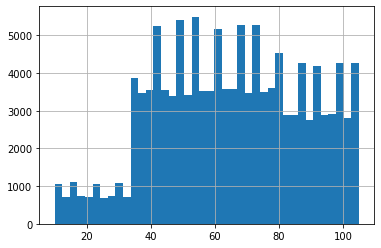

In [ ]:
df_transac['tran_amount'].hist(bins=40)

In [ ]:
df_transac['tk_s'] = df_transac['tran_amount'].apply(lambda x:1 if x<=40 else 0)
df_transac['tk_m'] = df_transac['tran_amount'].apply(lambda x:1 if 41<=x<=80 else 0)
df_transac['tk_l'] = df_transac['tran_amount'].apply(lambda x:1 if x>=81 else 0)

In [ ]:
# lag
df_transac['last_trans_date'] = df_transac.groupby('customer_id')['trans_date'].shift(1)
df_transac['isweekday'] = df_transac['trans_date'].dt.weekday.apply(lambda x: 1 if  x <= 5 else 0)
df_transac['isweekend'] = df_transac['trans_date'].dt.weekday.apply(lambda x: 0 if  x <= 5 else 1)
df_transac['year'] = df_transac['trans_date'].dt.year
df_transac['year_month'] = df_transac['trans_date'].dt.strftime('%Y-%m')
df_transac['datediff'] = (df_transac['trans_date'] - df_transac['last_trans_date']).dt.days

In [ ]:
df_transac.head()

,customer_id,trans_date,tran_amount,tk_s,tk_m,tk_l,last_trans_date,isweekday,isweekend,year,year_month,datediff
77247,CS1112,2011-06-15,56,0,1,0,NaT,1,0,2011,2011-06,NaN
89149,CS1112,2011-08-19,96,0,0,1,2011-06-15,1,0,2011,2011-08,65.0
68206,CS1112,2011-10-02,60,0,1,0,2011-08-19,0,1,2011,2011-10,44.0
36486,CS1112,2012-04-08,56,0,1,0,2011-10-02,0,1,2012,2012-04,189.0
93074,CS1112,2012-06-24,52,0,1,0,2012-04-08,0,1,2012,2012-06,77.0


In [ ]:
# get first transaction
first_date_df = df_transac.groupby('customer_id')['trans_date'].min().reset_index()
first_date_df.rename(columns = {'trans_date':'regis_date'}, inplace=True)
first_date_df.head()

,customer_id,regis_date
0,CS1112,2011-06-15
1,CS1113,2011-05-27
2,CS1114,2011-07-14
3,CS1115,2011-08-10
4,CS1116,2011-06-27


In [ ]:
df_transac_reg = df_transac.merge(first_date_df, how='left', on = 'customer_id')
df_transac_reg

,customer_id,trans_date,tran_amount,tk_s,tk_m,tk_l,last_trans_date,isweekday,isweekend,year,year_month,datediff,regis_date
0,CS1112,2011-06-15,56,0,1,0,NaT,1,0,2011,2011-06,NaN,2011-06-15
1,CS1112,2011-08-19,96,0,0,1,2011-06-15,1,0,2011,2011-08,65.0,2011-06-15
2,CS1112,2011-10-02,60,0,1,0,2011-08-19,0,1,2011,2011-10,44.0,2011-06-15
3,CS1112,2012-04-08,56,0,1,0,2011-10-02,0,1,2012,2012-04,189.0,2011-06-15
4,CS1112,2012-06-24,52,0,1,0,2012-04-08,0,1,2012,2012-06,77.0,2011-06-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124995,CS9000,2014-01-12,16,1,0,0,2013-10-01,0,1,2014,2014-01,103.0,2011-09-04
124996,CS9000,2014-05-08,20,1,0,0,2014-01-12,1,0,2014,2014-05,116.0,2011-09-04
124997,CS9000,2014-07-08,26,1,0,0,2014-05-08,1,0,2014,2014-07,61.0,2011-09-04
124998,CS9000,2014-08-24,35,1,0,0,2014-07-08,0,1,2014,2014-08,47.0,2011-09-04


# Cohort Analysis

In [ ]:
cohort = df_transac_reg.copy()
cohort['month_diff'] = (cohort['trans_date'] - cohort['regis_date']).dt.days // 30
cohort['year_month_regis'] = cohort['regis_date'].dt.strftime('%Y-%m')
cohort.head()

,customer_id,trans_date,tran_amount,tk_s,tk_m,tk_l,last_trans_date,isweekday,isweekend,year,year_month,datediff,regis_date,month_diff,year_month_regis
0,CS1112,2011-06-15,56,0,1,0,NaT,1,0,2011,2011-06,NaN,2011-06-15,0,2011-06
1,CS1112,2011-08-19,96,0,0,1,2011-06-15,1,0,2011,2011-08,65.0,2011-06-15,2,2011-06
2,CS1112,2011-10-02,60,0,1,0,2011-08-19,0,1,2011,2011-10,44.0,2011-06-15,3,2011-06
3,CS1112,2012-04-08,56,0,1,0,2011-10-02,0,1,2012,2012-04,189.0,2011-06-15,9,2011-06
4,CS1112,2012-06-24,52,0,1,0,2012-04-08,0,1,2012,2012-06,77.0,2011-06-15,12,2011-06


In [ ]:
cohort_pv = cohort.pivot_table(index='year_month_regis', columns = 'month_diff', values = 'customer_id', aggfunc='nunique' )
cohort_pv[0] = cohort_pv[0].astype(int)
for col in cohort_pv.columns[1:]:
  cohort_pv[col] = round(cohort_pv[col]/cohort_pv[0],2)
# cohort_pv.fillna(0, inplace=True)

cohort_pv.head()

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
year_month_regis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05,1344,0.33,0.34,0.35,0.34,0.32,0.33,0.34,0.32,0.33,0.31,0.34,0.33,0.30,0.33,0.34,0.34,0.35,0.32,0.35,0.33,0.33,0.31,0.35,0.34,0.33,0.33,0.31,0.32,0.33,0.31,0.33,0.33,0.30,0.34,0.31,0.33,0.35,0.33,0.32,0.34,0.34,0.31,0.31,0.33,0.31,0.17
2011-06,1804,0.33,0.34,0.31,0.33,0.31,0.34,0.32,0.34,0.33,0.31,0.32,0.31,0.32,0.32,0.32,0.31,0.34,0.33,0.33,0.31,0.31,0.32,0.34,0.32,0.30,0.32,0.31,0.33,0.33,0.34,0.35,0.32,0.32,0.32,0.32,0.33,0.32,0.34,0.31,0.31,0.33,0.32,0.31,0.31,0.22,0.01
2011-07,1215,0.35,0.34,0.33,0.33,0.31,0.34,0.31,0.33,0.33,0.31,0.33,0.32,0.31,0.32,0.34,0.32,0.31,0.34,0.34,0.31,0.34,0.31,0.33,0.33,0.35,0.34,0.32,0.30,0.33,0.33,0.32,0.30,0.34,0.32,0.33,0.33,0.32,0.32,0.31,0.34,0.31,0.34,0.32,0.22,0.00,NaN
2011-08,863,0.31,0.29,0.33,0.32,0.33,0.31,0.33,0.29,0.33,0.30,0.32,0.35,0.33,0.33,0.32,0.31,0.31,0.31,0.34,0.32,0.33,0.29,0.31,0.36,0.35,0.29,0.31,0.30,0.35,0.31,0.28,0.34,0.29,0.29,0.29,0.33,0.28,0.32,0.34,0.33,0.30,0.35,0.23,0.01,NaN,NaN
2011-09,467,0.25,0.33,0.36,0.35,0.30,0.32,0.28,0.30,0.27,0.39,0.36,0.31,0.32,0.30,0.33,0.33,0.33,0.37,0.36,0.31,0.35,0.33,0.33,0.29,0.35,0.32,0.32,0.32,0.31,0.31,0.33,0.31,0.29,0.30,0.32,0.36,0.33,0.33,0.34,0.27,0.28,0.24,0.00,NaN,NaN,NaN


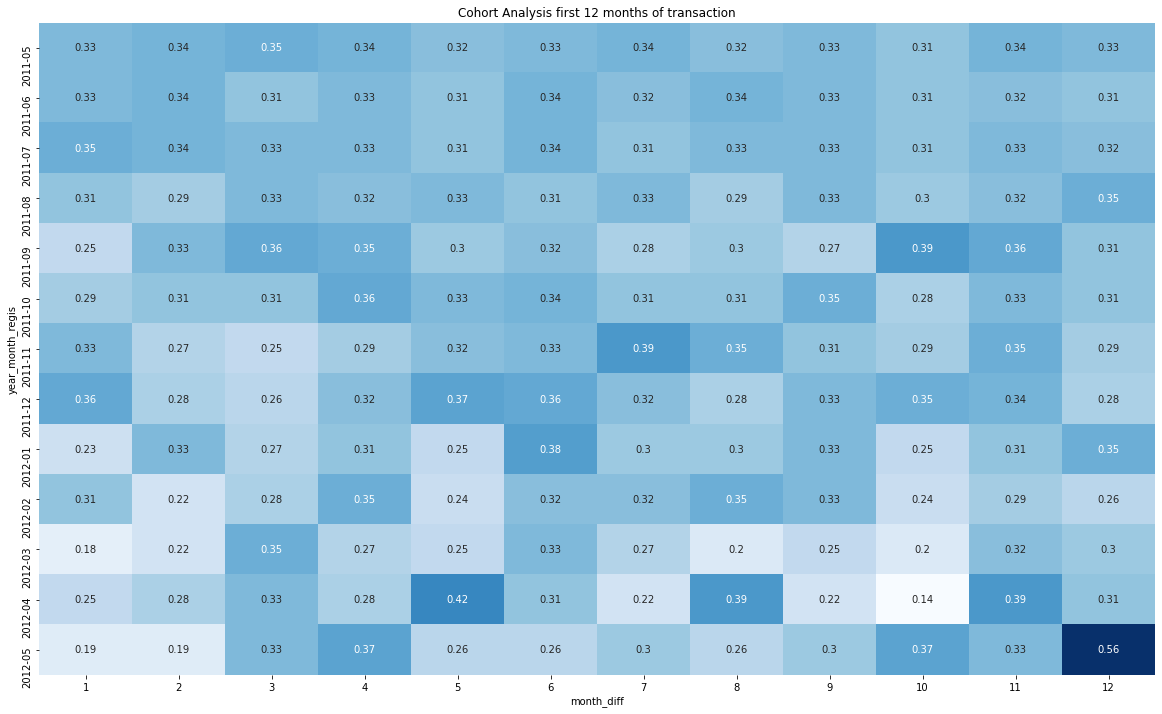

In [ ]:
# one year ( first 12 months of transaction)
plt.figure(figsize=(20,12))
sns.heatmap(cohort_pv.loc['2011-05':'2012-05', 1:12], cmap="Blues", cbar = False, annot = True)
plt.title('Cohort Analysis first 12 months of transaction');

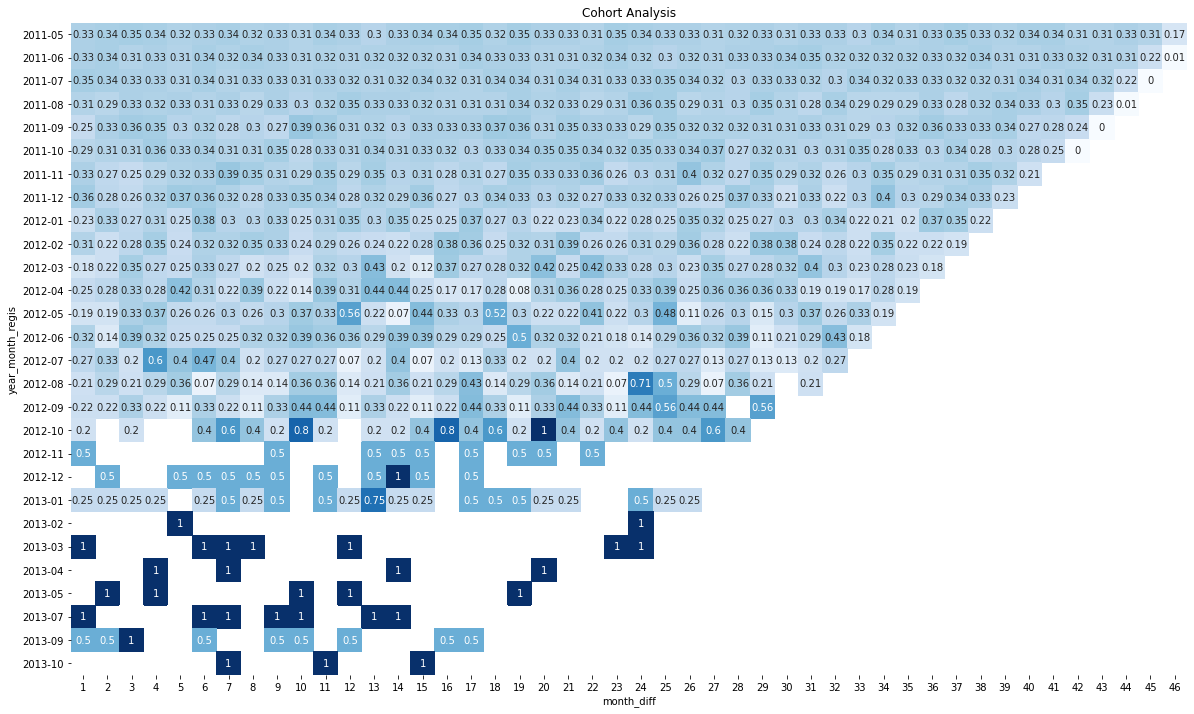

In [ ]:
# one year ( first 12 months of transaction)
plt.figure(figsize=(20,12))
sns.heatmap(cohort_pv.loc[:, 1:], cmap="Blues", cbar = False, annot = True)
plt.title('Cohort Analysis');

In [ ]:
# low retension rate in customer who registered after 2012-10

# Customer Single View

In [ ]:
df_transac_reg.head()

,customer_id,trans_date,tran_amount,tk_s,tk_m,tk_l,last_trans_date,isweekday,isweekend,year,year_month,datediff,regis_date
0,CS1112,2011-06-15,56,0,1,0,NaT,1,0,2011,2011-06,NaN,2011-06-15
1,CS1112,2011-08-19,96,0,0,1,2011-06-15,1,0,2011,2011-08,65.0,2011-06-15
2,CS1112,2011-10-02,60,0,1,0,2011-08-19,0,1,2011,2011-10,44.0,2011-06-15
3,CS1112,2012-04-08,56,0,1,0,2011-10-02,0,1,2012,2012-04,189.0,2011-06-15
4,CS1112,2012-06-24,52,0,1,0,2012-04-08,0,1,2012,2012-06,77.0,2011-06-15


In [ ]:
df_sgv = df_transac_reg.groupby('customer_id').agg({
                      'tran_amount' : ['sum', 'mean', 'std'],
                      'trans_date':['nunique','max','min'],
                      'tk_s':'sum',
                      'tk_m':'sum',
                      'tk_l':'sum',
                      'isweekday' :'sum',
                      'isweekend' :'sum',
                      'year' : 'nunique',
                      'year_month':'nunique',
                      'datediff' : ['mean', 'std']
                  })
df_sgv.columns = [ '_'.join(i) for i in df_sgv.columns ]
df_sgv.head()

,tran_amount_sum,tran_amount_mean,tran_amount_std,trans_date_nunique,trans_date_max,trans_date_min,tk_s_sum,tk_m_sum,tk_l_sum,isweekday_sum,isweekend_sum,year_nunique,year_month_nunique,datediff_mean,datediff_std
customer_id,,,,,,,,,,,,,,,
CS1112,1012,67.466667,19.766012,15,2015-01-14,2011-06-15,2,9,4,11,4,5,15,93.500000,50.873523
CS1113,1490,74.500000,21.254102,19,2015-02-09,2011-05-27,2,8,10,19,1,5,18,71.263158,54.685812
CS1114,1432,75.368421,21.341692,19,2015-02-12,2011-07-14,1,9,9,15,4,5,15,72.722222,73.693168
CS1115,1659,75.409091,18.151896,22,2015-03-05,2011-08-10,0,13,9,19,3,5,19,62.047619,55.413425
CS1116,857,65.923077,22.940000,13,2014-08-25,2011-06-27,1,8,4,12,1,4,13,96.250000,107.361010


In [ ]:
df_sgv.columns = ['ttl_spend', 'ticket_size', 'std_spend', 'ttl_visit', 'lastest_visit', 
                  'regis_date', 'ttl_tk_s', 'ttl_tk_m', 'ttl_tk_l' ,'ttl_weekday', 'ttl_weekend', 'active_year','active_month',
                  'avg_next_purchase', 'std_next_purchase']
df_sgv.head()              

,ttl_spend,ticket_size,std_spend,ttl_visit,lastest_visit,regis_date,ttl_tk_s,ttl_tk_m,ttl_tk_l,ttl_weekday,ttl_weekend,active_year,active_month,avg_next_purchase,std_next_purchase
customer_id,,,,,,,,,,,,,,,
CS1112,1012,67.466667,19.766012,15,2015-01-14,2011-06-15,2,9,4,11,4,5,15,93.500000,50.873523
CS1113,1490,74.500000,21.254102,19,2015-02-09,2011-05-27,2,8,10,19,1,5,18,71.263158,54.685812
CS1114,1432,75.368421,21.341692,19,2015-02-12,2011-07-14,1,9,9,15,4,5,15,72.722222,73.693168
CS1115,1659,75.409091,18.151896,22,2015-03-05,2011-08-10,0,13,9,19,3,5,19,62.047619,55.413425
CS1116,857,65.923077,22.940000,13,2014-08-25,2011-06-27,1,8,4,12,1,4,13,96.250000,107.361010


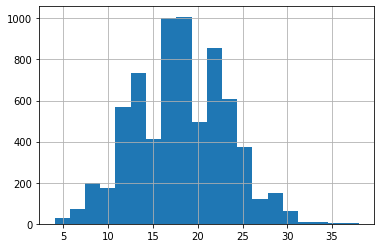

In [ ]:
df_sgv['ttl_visit'].hist(bins=20)

In [ ]:
import datetime
max_date = df_sgv['regis_date'].max()
days = datetime.timedelta(365)
regis_date_12month = max_date-days

In [ ]:
score_range = range(1, 6)

df_sgv['lastest_visit_score'] = pd.qcut(df_sgv['lastest_visit'], q=5, labels=score_range).astype(int)
df_sgv['regis_date_score'] = pd.qcut(df_sgv['regis_date'], q=5, labels=score_range).astype(int)
df_sgv['regis_last_12m'] = df_sgv['lastest_visit'].apply(lambda x: 1 if x >= regis_date_12month else 0)
df_sgv.head()

,ttl_spend,ticket_size,std_spend,ttl_visit,lastest_visit,regis_date,ttl_tk_s,ttl_tk_m,ttl_tk_l,ttl_weekday,ttl_weekend,active_year,active_month,avg_next_purchase,std_next_purchase,lastest_visit_score,regis_date_score,regis_last_12m
customer_id,,,,,,,,,,,,,,,,,,
CS1112,1012,67.466667,19.766012,15,2015-01-14,2011-06-15,2,9,4,11,4,5,15,93.500000,50.873523,3,2,1
CS1113,1490,74.500000,21.254102,19,2015-02-09,2011-05-27,2,8,10,19,1,5,18,71.263158,54.685812,4,1,1
CS1114,1432,75.368421,21.341692,19,2015-02-12,2011-07-14,1,9,9,15,4,5,15,72.722222,73.693168,4,3,1
CS1115,1659,75.409091,18.151896,22,2015-03-05,2011-08-10,0,13,9,19,3,5,19,62.047619,55.413425,5,4,1
CS1116,857,65.923077,22.940000,13,2014-08-25,2011-06-27,1,8,4,12,1,4,13,96.250000,107.361010,1,3,1


In [ ]:
target = pd.read_csv('/content/drive/MyDrive/CRM_Analytics/hw08-campaign_response/Retail_Data_Response.csv')
target.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
# not found 5 transaction in target
df_sgv_target = df_sgv.merge(target, how='inner', left_index=True, right_on ='customer_id')
df_sgv_target.set_index('customer_id', inplace=True)
df_sgv_target.drop(columns=['lastest_visit', 'regis_date'], inplace=True)
df_sgv_target.head()

,ttl_spend,ticket_size,std_spend,ttl_visit,ttl_tk_s,ttl_tk_m,ttl_tk_l,ttl_weekday,ttl_weekend,active_year,active_month,avg_next_purchase,std_next_purchase,lastest_visit_score,regis_date_score,regis_last_12m,response
customer_id,,,,,,,,,,,,,,,,,
CS1112,1012,67.466667,19.766012,15,2,9,4,11,4,5,15,93.500000,50.873523,3,2,1,0
CS1113,1490,74.500000,21.254102,19,2,8,10,19,1,5,18,71.263158,54.685812,4,1,1,0
CS1114,1432,75.368421,21.341692,19,1,9,9,15,4,5,15,72.722222,73.693168,4,3,1,1
CS1115,1659,75.409091,18.151896,22,0,13,9,19,3,5,19,62.047619,55.413425,5,4,1,1
CS1116,857,65.923077,22.940000,13,1,8,4,12,1,4,13,96.250000,107.361010,1,3,1,1


In [ ]:
df_sgv_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6884 entries, CS1112 to CS9000
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ttl_spend            6884 non-null   int64  
 1   ticket_size          6884 non-null   float64
 2   std_spend            6884 non-null   float64
 3   ttl_visit            6884 non-null   int64  
 4   ttl_tk_s             6884 non-null   int64  
 5   ttl_tk_m             6884 non-null   int64  
 6   ttl_tk_l             6884 non-null   int64  
 7   ttl_weekday          6884 non-null   int64  
 8   ttl_weekend          6884 non-null   int64  
 9   active_year          6884 non-null   int64  
 10  active_month         6884 non-null   int64  
 11  avg_next_purchase    6884 non-null   float64
 12  std_next_purchase    6884 non-null   float64
 13  lastest_visit_score  6884 non-null   int64  
 14  regis_date_score     6884 non-null   int64  
 15  regis_last_12m       6884 non-null  

In [ ]:
df_sgv_target['response'].value_counts()

0    6237
1     647
Name: response, dtype: int64

# Train-Validation-Test

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

# initial
RANDOM_STATE = 55
TRAIN_SIZE = 0.5
VALID_SIZE = 0.2
TEST_SIZE = 0.3


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X = df_sgv_target.drop(columns='response')
y = df_sgv_target['response']

X_train, X_test, y_train, y_test = train_test_split(
                                              X, y, 
                                              test_size = TEST_SIZE, 
                                              stratify = y,
                                              random_state = RANDOM_STATE
                                    )

X_train2, X_valid, y_train2, y_valid = train_test_split(
                                                X_train, y_train, 
                                                test_size= VALID_SIZE/(1-TEST_SIZE), 
                                                stratify = y_train,
                                                random_state= RANDOM_STATE
                                        )

for i in [X_train2, y_train2, X_valid, y_valid, X_test, y_test]:
  print(i.shape[0]/ X.shape[0])

# SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_sm, y_sm = sm.fit_sample(X_train2, y_train2)

0.49985473561882626
0.49985473561882626
0.20002905287623474
0.20002905287623474
0.300116211504939
0.300116211504939


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# XGB model

In [ ]:
X_valid = X_valid.to_numpy()
y_valid = y_valid.to_numpy()

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
xgb_model.fit(X_sm, y_sm, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)])

y_valid_pred = xgb_model.predict(X_valid)
y_test_pred = xgb_model.predict(X_test.to_numpy())

print('VALIDATION SET ------------------------------------')
print(classification_report(y_valid, y_valid_pred))
print('TEST SET ------------------------------------')
print(classification_report(y_test, y_test_pred))

[0]	validation_0-auc:0.693143
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.71274
[2]	validation_0-auc:0.71898
[3]	validation_0-auc:0.712759
[4]	validation_0-auc:0.732788
[5]	validation_0-auc:0.735471
[6]	validation_0-auc:0.731372
[7]	validation_0-auc:0.730928
[8]	validation_0-auc:0.726527
[9]	validation_0-auc:0.72926
[10]	validation_0-auc:0.725387
Stopping. Best iteration:
[5]	validation_0-auc:0.735471

VALIDATION SET ------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1248
           1       0.19      0.54      0.28       129

    accuracy                           0.74      1377
   macro avg       0.57      0.65      0.56      1377
weighted avg       0.87      0.74      0.79      1377

TEST SET ------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1872
           1      

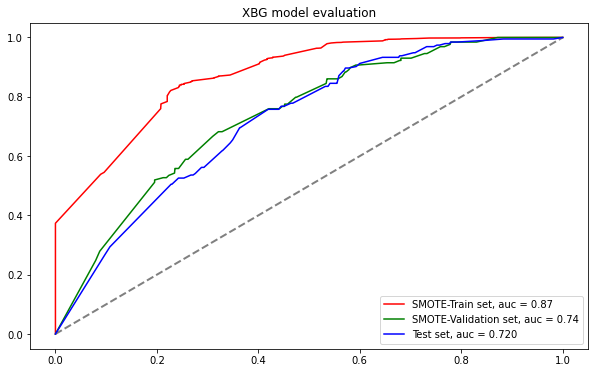

In [ ]:
plt.figure(figsize=(10,6))
# train set
y_prob_sm = xgb_model.predict_proba(X_sm)
fpr_train, tpr_train ,_ = roc_curve(y_sm, y_prob_sm[:,1])
auc_train = roc_auc_score(y_sm, y_prob_sm[:,1])

plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE-Train set, auc = {auc_train:.2f}')

# validation set
y_prob_valid = xgb_model.predict_proba(X_valid)
fpr_valid, tpr_valid ,_ = roc_curve(y_valid, y_prob_valid[:,1])
auc_valid = roc_auc_score(y_valid, y_prob_valid[:,1])

plt.plot(fpr_valid, tpr_valid, color='green', label=f'SMOTE-Validation set, auc = {auc_valid:.2f}')


# test set
y_prob_test = xgb_model.predict_proba(X_test.to_numpy())
fpr_test, tpr_test ,_ = roc_curve(y_test, y_prob_test[:,1])
auc_test = roc_auc_score(y_test, y_prob_test[:,1])

plt.plot([0,1],[0,1], color = 'grey', lw=2, ls ='--')

plt.plot(fpr_test, tpr_test, color='blue', label=f'Test set, auc = {auc_test:.3f}')
plt.legend()
plt.title('XBG model evaluation')
plt.show();

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 9.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491626 sha256=ae178a9352b1dcae63cf40d502794affcdd6c78e8a3e0a604dba3a08d58b1b5f
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


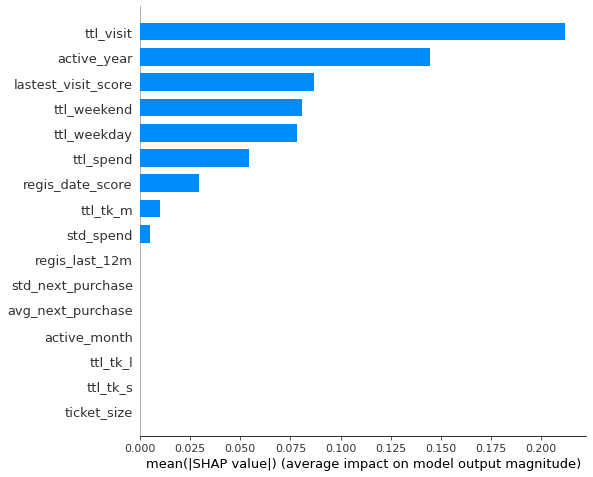

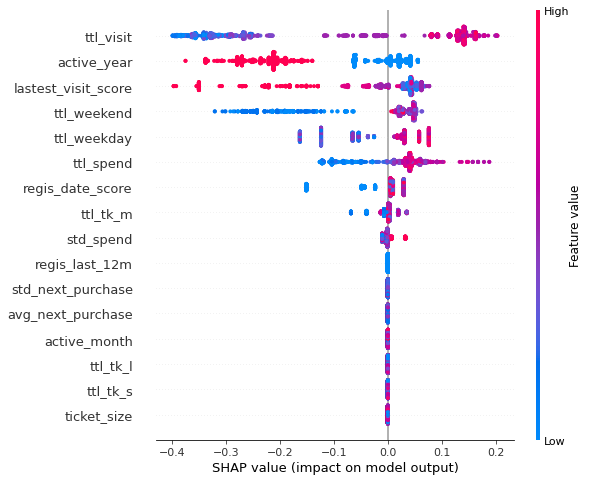

In [ ]:
# SHAP
import shap
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_valid)
shap.summary_plot(shap_values, X_valid,plot_type='bar', feature_names = X.columns)
shap.summary_plot(shap_values, X_valid, feature_names = X.columns)

# interesting features
# ['ttl_visit', 'active_year','lastest_visit_score','ttl_weekend','ttl_weekday','ttl_spend', 'regis_date_score','ttl_tk_m','std_spend']

# 2nd Attemp

In [ ]:
# initial
RANDOM_STATE = 0
TRAIN_SIZE = 0.6
VALID_SIZE = 0.2
TEST_SIZE = 0.2

COLS = ['ttl_visit', 'active_year','lastest_visit_score','ttl_weekend','ttl_weekday','ttl_spend', 'regis_date_score','ttl_tk_m','std_spend']


In [ ]:
X = df_sgv_target[COLS]
# X = df_sgv_target.drop(columns='response')
y = df_sgv_target['response']

X_train, X_test, y_train, y_test = train_test_split(
                                              X, y, 
                                              test_size = TEST_SIZE, 
                                              stratify = y,
                                              random_state = RANDOM_STATE
                                    )

X_train2, X_valid, y_train2, y_valid = train_test_split(
                                                X_train, y_train, 
                                                test_size= VALID_SIZE/(1-TEST_SIZE), 
                                                stratify = y_train,
                                                random_state= RANDOM_STATE
                                        )

for i in [X_train2, y_train2, X_valid, y_valid, X_test, y_test]:
  print(i.shape[0]/ X.shape[0])

# SMOTE - train set

sm = SMOTE(random_state=RANDOM_STATE)
X_sm, y_sm = sm.fit_sample(X_train2, y_train2)


# XGB model

xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              eval_metric='auc',
                              learning_rate = 0.03,
                              max_depth = 3)
xgb_model.fit(X_sm, y_sm, early_stopping_rounds=5, eval_set=[(X_valid.to_numpy(), y_valid)])

y_valid_pred = xgb_model.predict(X_valid.to_numpy())
y_test_pred = xgb_model.predict(X_test.to_numpy())

print('VALIDATION SET ------------------------------------')
print(classification_report(y_valid, y_valid_pred))
print('TEST SET ------------------------------------')
print(classification_report(y_test, y_test_pred))

0.5999418942475305
0.5999418942475305
0.20002905287623474
0.20002905287623474
0.20002905287623474
0.20002905287623474
[0]	validation_0-auc:0.684085
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.684085
[2]	validation_0-auc:0.684085
[3]	validation_0-auc:0.685528
[4]	validation_0-auc:0.685528
[5]	validation_0-auc:0.685485
[6]	validation_0-auc:0.69215
[7]	validation_0-auc:0.692101
[8]	validation_0-auc:0.697752
[9]	validation_0-auc:0.698122
[10]	validation_0-auc:0.697597
[11]	validation_0-auc:0.696231
[12]	validation_0-auc:0.696438
[13]	validation_0-auc:0.697017
[14]	validation_0-auc:0.698615
[15]	validation_0-auc:0.696475
[16]	validation_0-auc:0.698393
[17]	validation_0-auc:0.697384
[18]	validation_0-auc:0.697459
[19]	validation_0-auc:0.697822
Stopping. Best iteration:
[14]	validation_0-auc:0.698615

VALIDATION SET ------------------------------------


Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1247
           1       0.18      0.55      0.27       130

    accuracy                           0.72      1377
   macro avg       0.56      0.65      0.55      1377
weighted avg       0.87      0.72      0.78      1377

TEST SET ------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1248
           1       0.18      0.60      0.28       129

    accuracy                           0.71      1377
   macro avg       0.56      0.66      0.55      1377
weighted avg       0.87      0.71      0.77      1377



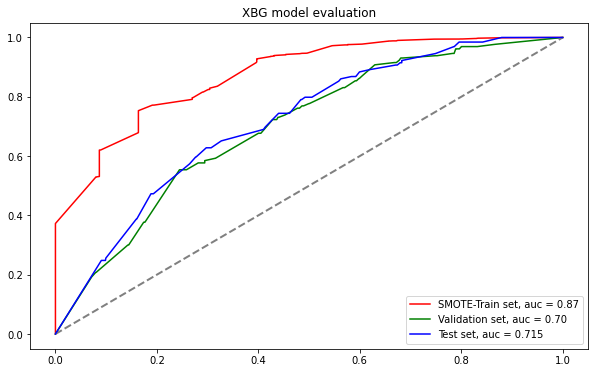

In [ ]:
plt.figure(figsize=(10,6))
# train set
y_prob_sm = xgb_model.predict_proba(X_sm)
fpr_train, tpr_train ,_ = roc_curve(y_sm, y_prob_sm[:,1])
auc_train = roc_auc_score(y_sm, y_prob_sm[:,1])

plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE-Train set, auc = {auc_train:.2f}')

# validation set
y_prob_valid = xgb_model.predict_proba(X_valid.to_numpy())
fpr_valid, tpr_valid ,_ = roc_curve(y_valid, y_prob_valid[:,1])
auc_valid = roc_auc_score(y_valid, y_prob_valid[:,1])

plt.plot(fpr_valid, tpr_valid, color='green', label=f'Validation set, auc = {auc_valid:.2f}')


# test set
y_prob_test = xgb_model.predict_proba(X_test.to_numpy())
fpr_test, tpr_test ,_ = roc_curve(y_test, y_prob_test[:,1])
auc_test = roc_auc_score(y_test, y_prob_test[:,1])

plt.plot([0,1],[0,1], color = 'grey', lw=2, ls ='--')

plt.plot(fpr_test, tpr_test, color='blue', label=f'Test set, auc = {auc_test:.3f}')
plt.legend(loc=4)
plt.title('XBG model evaluation')
plt.show();

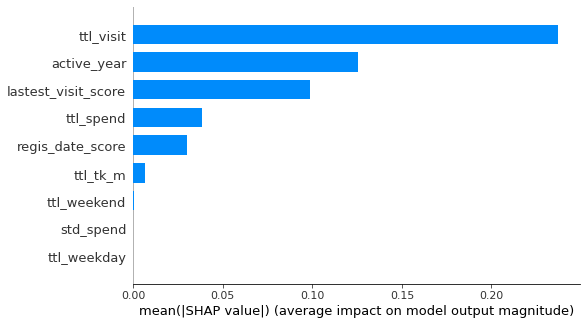

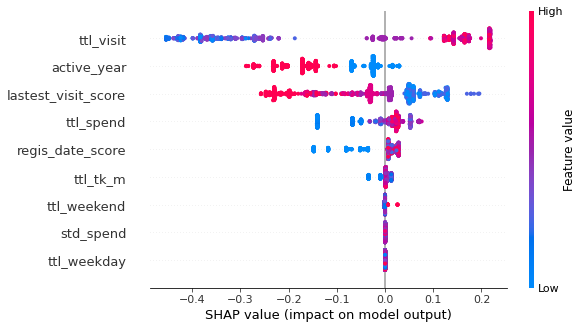

In [ ]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_valid)
shap.summary_plot(shap_values, X_valid,plot_type='bar', feature_names = X.columns)
shap.summary_plot(shap_values, X_valid, feature_names = X.columns)